In [1]:
from src.dl.loader import PatchDataset, PermutePatchDataset, splitDataset, BlockDataset
from src.utils.data import getBlockPandas
import numpy as np
from torch.utils.data import ConcatDataset
from src.dl.resnet import ModifiedResNet18, ModifiedResNet3d
from torch import nn
from torch.utils.data import DataLoader, sampler
from torch.utils.tensorboard import SummaryWriter
import torch
from sklearn.model_selection import KFold

In [2]:
writer = SummaryWriter('./log')

In [3]:
net = ModifiedResNet3d().cuda()

In [2]:
import os
import os.path
net = torch.load(os.path.join('data', 'bin', 'resnet50.pth'))

In [4]:
loss_fn = nn.SmoothL1Loss().cuda()
lr = 1e-3
optim = torch.optim.SGD([
    {'params': net.fc.weight, 'lr': 1e-2}
    ], lr=lr, momentum=0.3)
#optim = torch.optim.SGD(net.parameters(), lr=1e-1, momentum=0.3)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
#optim = torch.optim.Adam(net.parameters(), lr=lr, betas=[0.3, 0.1])
epoch = 100

In [5]:
dataset = BlockDataset()
data = getBlockPandas()
kf = KFold(n_splits=5, shuffle=True, random_state=10)

In [5]:
train_sets, test_set = splitDataset(6000, 5, dataset)
train_set = ConcatDataset(train_sets[1:])
validate_set = train_sets[0]
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
validate_dataloader = DataLoader(validate_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
print(dataset[0][0].shape)

torch.Size([1, 32, 32, 32])


In [6]:
nmse_mat = []
loss_mat = []
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
    train_sampler = sampler.SubsetRandomSampler(train_idx)
    val_sampler = sampler.SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler)
    nmse_list = []
    loss_list = []
    for i in range(epoch):
        total_loss = 0
        predy = np.array([])
        y = np.array([])
        net.train()
        for step, [img, labels, score] in enumerate(train_loader):
            img = img.cuda()
            labels = labels.cuda()
            score = score.cuda()
            output = net(img, labels).squeeze(-1)
            loss = loss_fn(output.float(), score.float())

            optim.zero_grad()
            loss.backward()
            optim.step()
            #scheduler.step()
        
        net.eval()
        with torch.no_grad():
            for step, [img, labels, score] in enumerate(val_loader):
                img = img.cuda()
                labels = labels.cuda()
                score = score.cuda()
                output = net(img, labels).squeeze(-1)
                loss = loss_fn(output.float(), score.float())
        
                predy = np.concatenate((predy, output.cpu().detach().numpy()), axis=0)
                y = np.concatenate((y, score.cpu().detach().numpy()), axis=0)

                total_loss += loss.item()

        nmse = np.sum((y - predy) ** 2) / np.sum(y ** 2)
        print('epoch {}, loss {}, nmse {}'.format(i, total_loss, nmse))
        writer.add_scalar('Loss', total_loss, i)
        writer.add_scalar('NMSE', nmse, i)
        nmse_list.append(nmse)
        loss_list.append(total_loss)
    nmse_mat.append(nmse_list)
    loss_mat.append(loss_list)

writer.close()

epoch 0, loss 3.0689573492854834, nmse 0.2818355012438734
epoch 1, loss 3.0391825726255774, nmse 0.2789725280393447
epoch 2, loss 2.9755198527127504, nmse 0.273249502684904
epoch 3, loss 2.9521263977512717, nmse 0.2711024803358737
epoch 4, loss 2.929272400215268, nmse 0.2690284882493292
epoch 5, loss 2.917003949172795, nmse 0.26781484474316625
epoch 6, loss 2.919982830993831, nmse 0.2681112297753875
epoch 7, loss 2.884369008243084, nmse 0.26487288791177616
epoch 8, loss 2.899784126318991, nmse 0.2662658504616421
epoch 9, loss 2.8636568719521165, nmse 0.26296326719518603
epoch 10, loss 2.8617462385445833, nmse 0.26282120840133244
epoch 11, loss 2.8497678078711033, nmse 0.26163568224715494
epoch 12, loss 2.8509399136528373, nmse 0.2618097830416743
epoch 13, loss 2.8421672508120537, nmse 0.2610467014629343
epoch 14, loss 2.8222134420648217, nmse 0.2591979750445215
epoch 15, loss 2.8275362718850374, nmse 0.259577038779238
epoch 16, loss 2.8104434218257666, nmse 0.25806258309789715
epoch 17

KeyboardInterrupt: 

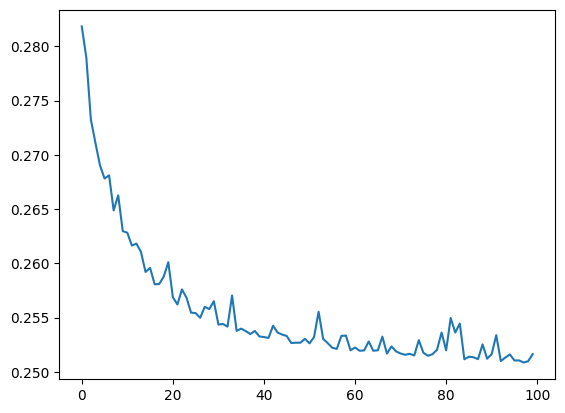

In [12]:
import matplotlib.pyplot as plt
plt.plot(nmse_mat[0])

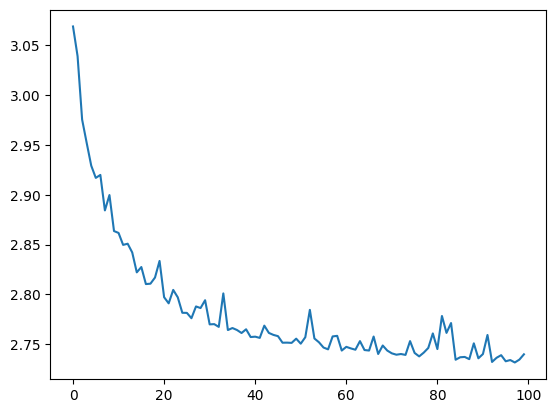

In [13]:
plt.plot(loss_mat[0])